# P-Median Location Problem
## Random Sampling Algorithm - Instance 1

In [1]:
#Importing the required libraries
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import copy

In [2]:
#defining the class cities
class cities:
    def __init__(self, num_cities):
        self._num_cities = num_cities
        self._rangelct = 100000
        self._coord_x = None
        self._coord_y = None
        self._distance_matrix = None
        self.rand_seed = 1 #Seed to generate cities
        self._cities_id_dict = {}

        if self.rand_seed is not None:
            random.seed(self.rand_seed)

        if self._distance_matrix is None:
            self.create_distance_matrix()
        
        if self._cities_id_dict == {}:
            self.create_cities_id_dict()
        


    @property
    def num_cities(self):
        return self._num_cities
    @num_cities.setter
    def num_cities(self, num_cities):
        self._num_cities = num_cities

    @property
    def coord_x(self):
        if self._coord_x is None:
            self._coord_x = random.choices(range(self._rangelct), k=self._num_cities)
        return self._coord_x
    @property
    def coord_y(self):
        if self._coord_y is None:
            self._coord_y = random.choices(range(self._rangelct), k=self._num_cities)
        return self._coord_y
    
    @property
    def distance_matrix(self):
        return self._distance_matrix
    
    @property
    def cities_id_dict(self):
        return self._cities_id_dict
    
    @property
    def rangelct(self):
        return self._rangelct
    
    def create_distance_matrix(self):
    #Calculates the distance matrix between the cities
        if self._distance_matrix is None:
            distance_matrix = np.empty((self._num_cities, self._num_cities))
            for i in range(self._num_cities):
                for j in range(self._num_cities):
                    distance_matrix[i][j] = math.sqrt((self.coord_x[i] - self.coord_x[j])**2 + (self.coord_y[i] - self.coord_y[j])**2)
            #Assigns a large number to the diagonal of the distance matrix to avoid selecting the same location twice
            distance_matrix[np.diag_indices(self._num_cities)] = self._rangelct-1
            #Assign
            self._distance_matrix = distance_matrix

    #Creates a dictionary with the cities id as keys and the coordinates as values:
    def create_cities_id_dict(self):
        #Creates a dictionary with the cities id as keys and the coordinates as values: 
        # Start with 0
        for i in range(self._num_cities):
            self._cities_id_dict[i] = [self.coord_x[i], self.coord_y[i]]



#Instantiate the class cities with 100 cities
City_inst1 = cities(100)


#distance from set coordinates to list cities
def distance_from_coord(list_cities, coord, df_cities_coord):
    df_cities = df_cities_coord.loc[list_cities]
    df_cities['dist_cntr'] = df_cities.apply(lambda row: math.sqrt(((row['coord_x']-coord[0])**2) +((row['coord_y']-coord[1])**2)), axis=1)
    df_cities.sort_values(by=['dist_cntr'], inplace=True)

    # Invert each distance, handle division by zero
    df_cities['inv_dist'] = df_cities['dist_cntr'].apply(lambda x: 1/x if x != 0 else 0)
    # Calculate sum of inverted distances
    inv_dist_sum = df_cities['inv_dist'].sum()
    # Compute the normalizer
    normalizer = 1/inv_dist_sum
    # Multiply normalizer with each inverted distance
    df_cities['norm'] = df_cities['inv_dist'] * normalizer
    # If you no longer need the 'inv_dist' column, you can drop it
    df_cities.drop('inv_dist', axis=1, inplace=True)
    return df_cities

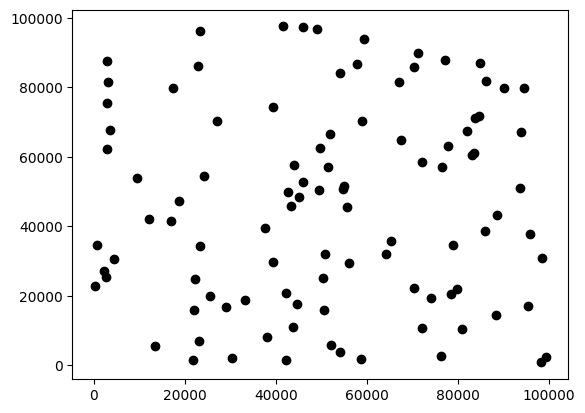

In [3]:
plt.plot(City_inst1.coord_x, City_inst1.coord_y, 'o', color='black');

## Initial Solution

In [4]:
#Generate list of 100 numbers
random.seed(1)
start_list = random.sample(range(0, City_inst1.num_cities), City_inst1.num_cities)
print(start_list)

[17, 72, 97, 8, 32, 15, 63, 57, 60, 83, 48, 26, 12, 62, 3, 49, 55, 77, 0, 92, 34, 29, 75, 13, 40, 85, 2, 74, 69, 1, 89, 27, 54, 98, 28, 56, 93, 35, 14, 22, 61, 43, 59, 71, 78, 18, 70, 88, 86, 41, 6, 11, 82, 46, 67, 7, 21, 95, 68, 42, 87, 19, 45, 31, 47, 25, 73, 30, 94, 23, 79, 39, 76, 58, 5, 64, 99, 91, 52, 24, 33, 80, 16, 66, 90, 96, 50, 84, 36, 44, 81, 10, 9, 38, 20, 4, 51, 65, 37, 53]


In [5]:
random.seed(1)
num_facilities = 15
center_of_coord = [City_inst1.rangelct/2, City_inst1.rangelct/2]


#Initiate data frame with cities id and coordinates
df_cities_coord = pd.DataFrame(City_inst1.cities_id_dict, ['coord_x', 'coord_y']).T

#Randomly sample x number of facilities from the list of cities
rand_open_fac_list = random.sample(start_list, num_facilities)

#Get dataframe of cities with distance from center
df_open_fac = distance_from_coord(rand_open_fac_list, center_of_coord, df_cities_coord)

#Sorted data frame index to list
list_open_fac = df_open_fac.index.tolist()

#Function for solution encoding
def solution_encoding(city_num, fac_list):
    binary_enc = []
    for _ in list(range(city_num)):
        binary_enc.append(0)
    for idx in fac_list:
        binary_enc[idx] = 1
    return binary_enc

fac_binary_sol = solution_encoding(City_inst1.num_cities,list_open_fac)
cities_binary_sol = None

In [6]:
#iterate through list of facilities
remaining_cities = list(set(range(City_inst1.num_cities)) - set(list_open_fac))

#Facility to cities dict
fac_to_cities_dict = {}
remaining_fac = len(list_open_fac)


for facility in list_open_fac:
    fac_to_cities_dict[facility] = []

    #Get facility coordinates [x,y]
    facility_coord = City_inst1.cities_id_dict[facility]

    #Remove currently iterated city
    renaining_cities = list(set(remaining_cities) - set([facility]))

    #Get list of cities sorted by distance from facility
    df_fac_to_cities = distance_from_coord(renaining_cities, facility_coord, df_cities_coord)

    if len(remaining_cities)//remaining_fac == 1:
        random_num = 1
    elif remaining_fac <= 1:
        random_num = len(remaining_cities)
    else:
        lower_bound = int(len(remaining_cities)*0.40)
        upper_bound = int(len(remaining_cities)*0.60)
        random_num = random.randint(lower_bound, upper_bound)
        
    remaining_fac = remaining_fac - 1


    #Cut off list based on rand number
    considered_cities = []
    weights_index = []
    if random_num == 0:
        fac_to_cities_dict[facility] = []
    else:
        if random_num*2 <= len(remaining_cities):
            considered_cities = df_fac_to_cities.head(random_num*2).index.tolist()
            df_consid_cities = distance_from_coord(considered_cities, facility_coord, df_cities_coord)
            weights_index = df_consid_cities['norm'].to_list()
        elif random_num <= len(remaining_cities):
            considered_cities = df_fac_to_cities.head(random_num).index.tolist()
            df_consid_cities = distance_from_coord(considered_cities, facility_coord, df_cities_coord)
            weights_index = df_consid_cities['norm'].to_list()

        #Sample remaining cities randomly based on probability
        rand_cities_to_fac = np.random.choice(considered_cities, size=random_num, replace=False, p=weights_index)
        fac_to_cities_dict[facility] = rand_cities_to_fac
        remaining_cities = list(set(remaining_cities) - set(rand_cities_to_fac))


#Sum of distances from facilities to cities
total_dist = 0
for key, value in fac_to_cities_dict.items():
    for city in value:
        total_dist += City_inst1.distance_matrix[key][city]
print("total_dist", total_dist)

cities_binary_sol = copy.deepcopy(fac_binary_sol)
for key, value in fac_to_cities_dict.items():
    cities_binary_sol[key] = solution_encoding(City_inst1.num_cities,value)

total_dist 2817033.7209031023


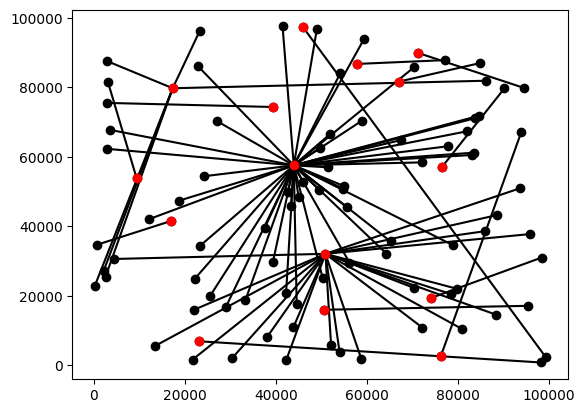

In [7]:
#Dictionary to dataframe of initial solution
data = [(key, value) for key, value in fac_to_cities_dict.items() for value in value]
df_init_sol = pd.DataFrame(data, columns=['facility', 'cities'])

#Retrieve facility and cities columns as lists
fac_col = df_init_sol['facility'].tolist()
city_col = df_init_sol['cities'].tolist()

fac_xy_coord_list = []
for facility in fac_col:
    fac_coord = City_inst1.cities_id_dict[facility]
    fac_xy_coord_list.append(fac_coord)

city_xy_coord_list = []
for city in city_col:
    city_coord = City_inst1.cities_id_dict[city]
    city_xy_coord_list.append(city_coord)

plt.plot(City_inst1.coord_x, City_inst1.coord_y, 'o', color='black');
for fac, city in zip(fac_xy_coord_list, city_xy_coord_list):
    plt.plot([fac[0],city[0]],[fac[1],city[1]],'k-')
for key in fac_to_cities_dict.keys():
    coord = City_inst1.cities_id_dict[key]
    plt.plot([coord[0]],[coord[1]],'o', color='red')

## Iterated Solution

In [8]:
#Generate list of 100 numbers
random.seed(1)
start_list = random.sample(range(0, City_inst1.num_cities), City_inst1.num_cities)
print(start_list)

[17, 72, 97, 8, 32, 15, 63, 57, 60, 83, 48, 26, 12, 62, 3, 49, 55, 77, 0, 92, 34, 29, 75, 13, 40, 85, 2, 74, 69, 1, 89, 27, 54, 98, 28, 56, 93, 35, 14, 22, 61, 43, 59, 71, 78, 18, 70, 88, 86, 41, 6, 11, 82, 46, 67, 7, 21, 95, 68, 42, 87, 19, 45, 31, 47, 25, 73, 30, 94, 23, 79, 39, 76, 58, 5, 64, 99, 91, 52, 24, 33, 80, 16, 66, 90, 96, 50, 84, 36, 44, 81, 10, 9, 38, 20, 4, 51, 65, 37, 53]


In [19]:
random.seed(1)
num_facilities = 15
center_of_coord = [City_inst1.rangelct/2, City_inst1.rangelct/2]


#Initiate data frame with cities id and coordinates
df_cities_coord = pd.DataFrame(City_inst1.cities_id_dict, ['coord_x', 'coord_y']).T


Opt_fac_dict = {}
Opt_dist = float('inf') 
Opt_dist_list = [Opt_dist]
Opt_open_fac_list = []
iteration=0
program_starts = time.time()
cputime_i=[0] 

while cputime_i[-1]<300:
    iteration+=1 

        #Randomly sample x number of facilities from the list of cities
    rand_open_fac_list = random.sample(start_list, num_facilities)

    #Get dataframe of cities with distance from center
    df_open_fac = distance_from_coord(rand_open_fac_list, center_of_coord, df_cities_coord)

    #Sorted data frame index to list
    list_open_fac = df_open_fac.index.tolist()
    # print(list_open_fac)


    #iterate through list of facilities
    remaining_cities = list(set(range(City_inst1.num_cities)) - set(list_open_fac))

    #Facility to cities dict
    fac_to_cities_dict = {}
    remaining_fac = len(list_open_fac)


    for facility in list_open_fac:
        fac_to_cities_dict[facility] = []

        #Get facility coordinates [x,y]
        facility_coord = City_inst1.cities_id_dict[facility]

        #Remove currently iterated city
        renaining_cities = list(set(remaining_cities) - set([facility]))

        #Get list of cities sorted by distance from facility
        df_fac_to_cities = distance_from_coord(renaining_cities, facility_coord, df_cities_coord)

        if len(remaining_cities)//remaining_fac == 1:
                random_num = 1
        elif remaining_fac <= 1:
                random_num = len(remaining_cities)
        else:
            lower_bound = int(len(remaining_cities)*0.1)
            upper_bound = int(len(remaining_cities)*0.3)
            random_num = random.randint(lower_bound, upper_bound)
            
        remaining_fac = remaining_fac - 1
        # print("random num", random_num)


        #Cut off list based on rand number
        considered_cities = []
        weights_index = []
        if random_num == 0:
            fac_to_cities_dict[facility] = []
        else:
            if random_num*1.5 <= len(remaining_cities):
                considered_cities = df_fac_to_cities.head(random_num*2).index.tolist()
                df_consid_cities = distance_from_coord(considered_cities, facility_coord, df_cities_coord)
                weights_index = df_consid_cities['norm'].to_list()
            elif random_num <= len(remaining_cities):
                considered_cities = df_fac_to_cities.head(random_num).index.tolist()
                df_consid_cities = distance_from_coord(considered_cities, facility_coord, df_cities_coord)
                weights_index = df_consid_cities['norm'].to_list()


            #Sample remaining cities randomly based on probability
            rand_cities_to_fac = np.random.choice(considered_cities, size=random_num, replace=False, p=weights_index)
            fac_to_cities_dict[facility] = rand_cities_to_fac
            remaining_cities = list(set(remaining_cities) - set(rand_cities_to_fac))

    #Sum of distances from facilities to cities
    total_dist = 0
    for key, value in fac_to_cities_dict.items():
        for city in value:
            total_dist += City_inst1.distance_matrix[key][city]
    
    if total_dist < Opt_dist:
        Opt_dist = total_dist
        Opt_fac_dict = copy.deepcopy(fac_to_cities_dict)
        Opt_open_fac_list = copy.deepcopy(list_open_fac)
        print(Opt_dist)

    now = time.time()
    Opt_dist_list.append(Opt_dist)
    cputime_i.append(now-program_starts)

#Facilities and Cities Binary Solution Encoding
it_fac_binary_sol = solution_encoding(City_inst1.num_cities,Opt_open_fac_list)
it_cities_binary_sol = copy.deepcopy(fac_binary_sol)
for key, value in Opt_fac_dict.items():
    it_cities_binary_sol[key] = solution_encoding(City_inst1.num_cities,value)
print(it_cities_binary_sol)

2421682.0958313
2405862.1197555126
2404899.2397462395
2044857.1741873187
1859582.2398514468
1790184.9461510582
1764116.2357082907
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], 0, 0, 0, 0, 0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1764116.2357082907


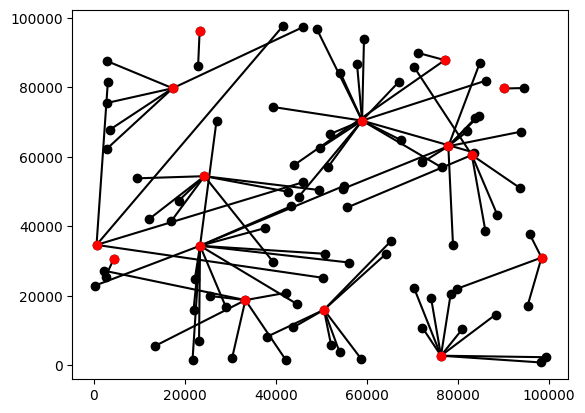

In [20]:
data = [(key, value) for key, value in Opt_fac_dict.items() for value in value]
df_init_sol = pd.DataFrame(data, columns=['facility', 'cities'])

print(Opt_dist)

fac_col = df_init_sol['facility'].tolist()
city_col = df_init_sol['cities'].tolist()


fac_xy_coord_list = []
for facility in fac_col:
    fac_coord = City_inst1.cities_id_dict[facility]
    fac_xy_coord_list.append(fac_coord)

city_xy_coord_list = []
for city in city_col:
    city_coord = City_inst1.cities_id_dict[city]
    city_xy_coord_list.append(city_coord)

plt.plot(City_inst1.coord_x, City_inst1.coord_y, 'o', color='black');
for fac, city in zip(fac_xy_coord_list, city_xy_coord_list):
    plt.plot([fac[0],city[0]],[fac[1],city[1]],'k-')
for key in Opt_fac_dict.keys():
    coord = City_inst1.cities_id_dict[key]
    plt.plot([coord[0]],[coord[1]],'o', color='red')

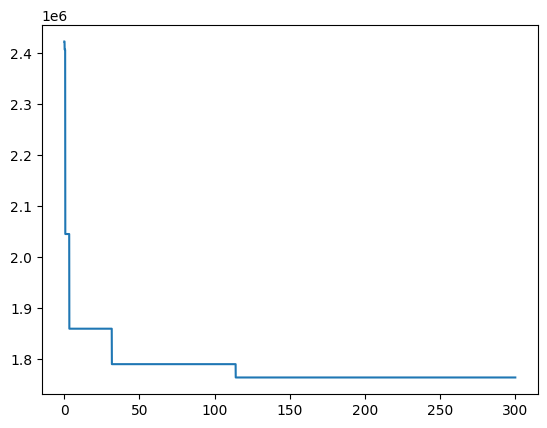

In [21]:
plt.plot(cputime_i[1:],Opt_dist_list[1:])